# Flux Sweeping via SRS

[srsinst pacakge](https://github.com/thinkSRS/srsinst.dc205)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from flux_fit import *
from utils import *

Connect to the instruments

In [4]:
!python -m srsinst.dc205

In [5]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

Successfully connected to Agilent Network Analyzer E5071B
Successfully connected to Keithley 2400 SourceMeter
Successfully connected to Rohde&Schwarz RF Source
Successfully connected to SignalCore SC5511A Signal Generator_10002F25
Successfully connected to SignalCore SC5511A Signal Generator_1000334C
Successfully connected to Vaunix Lab Brick Digital Attenuator


In [6]:
vs = connect_SRS()
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25']
Drive= instruments['SignalCore SC5511A Signal Generator_1000334C']
TWPA_PUMP = instruments['Rohde&Schwarz RF Source']

initialize_instruments(VNA, DA, SMU, LO, Drive, vs, TWPA_PUMP)

Since we only need the VNA and SRS for this measurement- lets make sure they are connected and ready to go. 

In [8]:
vs.check_id()


('DC205', 's/n20500691', 'ver1.80')

In [ ]:
VNA.isRunning()

True

Setting up the paths for storing the Labber file.

In [9]:
# get the time module
import time
import os
import logging

SPATH = r"G:\Shared drives\Labber\Data\{}\{}\Data_{}\\".format(time.strftime("%Y"), time.strftime("%m"), time.strftime("%m%d"))

figpath = SPATH + r"Figures\\"
if not os.path.exists(figpath):
    os.makedirs(figpath)
print(f"Saving path of Labber data to {SPATH}")
print(f"Saving figures to {figpath}")
logging.basicConfig(filename=SPATH+f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log',filemode='w',level=logging.INFO)


Saving path of Labber data to G:\Shared drives\Labber\Data\2025\04\Data_0402\\
Saving figures to G:\Shared drives\Labber\Data\2025\04\Data_0402\\Figures\\


Either set the VNA settings manually and grab them.

In [10]:
VNA.getInstrConfig()

{'S11 - Enabled': False,
 'S21 - Enabled': True,
 'S12 - Enabled': False,
 'S22 - Enabled': False,
 'S11': {'y': array([], dtype=float64), 't0': 0.0, 'dt': 1.0, 'shape': [0]},
 'S21': {'y': array([3.6908310e-05+3.2143864e-05j, 3.6747300e-05+3.5069152e-05j,
         4.1524050e-05+3.4500281e-05j, ..., 3.6558256e-05+2.0064932e-05j,
         3.8510472e-05+1.7225490e-05j, 3.8030099e-05+2.0043215e-05j],
        dtype=complex64),
  't0': 5755975000.0,
  'dt': 31250.0,
  'shape': [1601]},
 'S12': {'y': array([], dtype=float64), 't0': 0.0, 'dt': 1.0, 'shape': [0]},
 'S22': {'y': array([], dtype=float64), 't0': 0.0, 'dt': 1.0, 'shape': [0]},
 'S11 - Value': 0j,
 'S21 - Value': 0j,
 'S12 - Value': 0j,
 'S22 - Value': 0j,
 'Output enabled': True,
 'Output power': 5.0,
 'Trigger': True,
 'IF bandwidth': 1000.0,
 'Average': True,
 '# of averages': 50.0,
 'Wait for new trace': True,
 'Electrical Delay': 8.2417e-08,
 'Phase Offset': 0.0,
 'Range type': 'Center - Span',
 'Center frequency': 5780975000.

Or just set them in the code. 

```python

In [17]:
VNA.setValue('Output enabled',True)
VNA.setValue('Range type','Start - Stop')
VNA.setValue('Start frequency', 5.7E9)
VNA.setValue('Stop frequency', 5.8E9)
VNA.setValue('# of averages', 20)
VNA.setValue('Average',True)
VNA.setValue('Wait for new trace', True)

True

Testing the VNA settings by grabbing a trace

c:\ProgramData\Anaconda3\envs\resonator-fitting-env\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


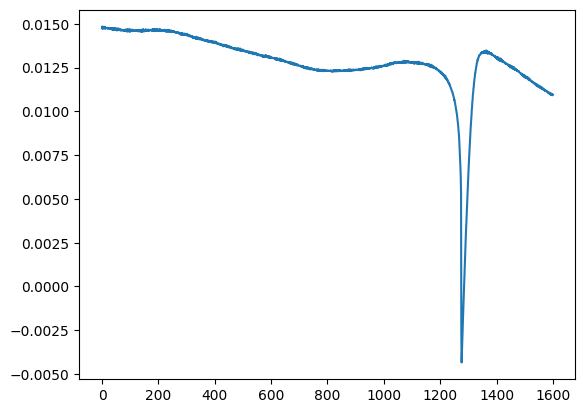

In [18]:
dBG = VNA.getValue('S21')
xBG = np.arange(dBG['t0'],dBG['t0']+dBG['shape'][0]*dBG['dt'],dBG['dt'])
zBG = dBG['y']
plt.plot(zBG)
plt.show()

In [19]:
#voltages = np.arange(-74E-3,72E-3,2E-3)
voltages = np.arange(0,4E-3,2E-3)

# reverse order
#voltages = np.flip(voltages)
voltages, len(voltages)

(array([0.   , 0.002]), 2)

In [20]:
labber_file_name = "test2"

lfVNA = Labber.createLogFile_ForData(os.path.join(SPATH, f'{labber_file_name}_flux_sweep'),
                                      [{'name':'VNA - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Voltage','values':voltages,'unit':'V'}])

In [21]:
for voltage in tqdm(voltages, desc='Voltage Sweep', unit='V'):  # Add tqdm progress bar
    print(voltage)
    logging.info(f'Starting Voltage = {voltage:.3f}\\n')
    set_flux_bias_srs(voltage, step=5E-5)
    sleep(0.05)
    dData = VNA.getValue('S21')
    zData = dData['y']
    xBG = np.arange(dData['t0'],dData['t0']+dData['shape'][0]*dData['dt'],dData['dt'])
    td2 = Labber.getTraceDict(zData,x0=xBG[0],x1=xBG[-1])
    lfVNA.addEntry({'VNA - S21':td2})

Voltage Sweep:   0%|          | 0/2 [00:00<?, ?V/s]

0.0
Setting FFL bias to 0.0 mV from 0.0 mV


Voltage Sweep:  50%|█████     | 1/2 [00:33<00:33, 33.71s/V]

0.002
Setting FFL bias to 2.0 mV from 0.0 mV


Voltage Sweep: 100%|██████████| 2/2 [01:27<00:00, 43.99s/V]


Ensure that the flux bias is set back to zero.

In [22]:
set_flux_bias_srs(0, step=5E-5)

Setting FFL bias to 0.0 mV from 2.0 mV
